In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
#from model_conv1 import ConvNet1
from mlp import MLP

DIR_PATH = os.getcwd() + '/../'

In [2]:
#model = ConvNet1(n_classes=6)
#model_mlp = MLP(layers_dim=(256*256*3, 2048, 512, 7))
model_resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False, num_classes=7)
print('MODEL INFO:', model_resnet, sep='\n')

Using cache found in /homes/hzd21/.cache/torch/hub/pytorch_vision_v0.10.0


MODEL INFO:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpl

In [3]:
sum_total_learnable_params = 0
for param in model_resnet.parameters():
    print(param.shape)
    sum_total_learnable_params += np.prod(np.array(param.shape))
print("Number of learnable parameters:", sum_total_learnable_params)

torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
t

In [4]:
data_traj = np.load(DIR_PATH + 'data/demo_reach_object_22_07_07_10_51_44.npz', allow_pickle=True)

x = data_traj['demo_image_sequences']
y = data_traj['demo_action_sequences']

n_seqs = len(y)
print('Number of sequences:', n_seqs)

Number of sequences: 178


In [5]:
# Split

n_test_seqs = 10
n_val_seqs = 20
n_train_seqs = 140

test_x_seqs = x[: n_test_seqs]
test_y_seqs = y[: n_test_seqs]

val_x_seqs = x[n_test_seqs : n_test_seqs+n_val_seqs]
val_y_seqs = y[n_test_seqs : n_test_seqs+n_val_seqs]

train_x_seqs = x[n_test_seqs+n_val_seqs : n_test_seqs+n_val_seqs+n_train_seqs]
train_y_seqs = y[n_test_seqs+n_val_seqs : n_test_seqs+n_val_seqs+n_train_seqs]

In [6]:
data_seq = train_x_seqs, train_y_seqs, val_x_seqs, val_y_seqs, test_x_seqs, test_y_seqs
data_concat = tuple(map(np.concatenate, data_seq))
train_x, train_y, val_x, val_y, test_x, test_y = data_concat
for data in data_concat:
    print(data.shape)

(19572, 256, 256, 3)
(19572, 7)
(2521, 256, 256, 3)
(2521, 7)
(1250, 256, 256, 3)
(1250, 7)


In [7]:
for i in range(3):
    print(train_x[:,:,:,i].min(), train_x[:,:,:,i].max())

0.0 1.0
0.0 1.0
0.0 1.0


In [8]:
for i in range(7):
    print(train_y[:,i].min(), train_y[:,i].max())

-0.004583074380803431 0.004495219079719367
-0.004292269969158852 0.004255458825090781
-0.004999984723689064 0.001909017562866211
-0.012499075562036941 0.012499550914489312
-0.012468136622773249 0.012484893246380968
-0.012499669985887934 0.012496865519618974
-0.9999999962992897 -0.9999218760149191


In [52]:
'mean =', train_y.mean(axis=0), 'std =', train_y.std(axis=0)

('mean =',
 array([ 1.43829243e-04, -1.25095708e-04, -3.39056340e-03, -9.48246625e-05,
         2.33874860e-04, -3.67510995e-04, -9.99957146e-01]),
 'std =',
 array([1.30591054e-03, 2.48425228e-03, 1.60129421e-03, 4.28247242e-03,
        4.15962985e-03, 7.06149528e-03, 3.72335535e-05]))

In [9]:
2/0.4, 1/0.025, 1/0.05

(5.0, 40.0, 20.0)

In [10]:
def normalize(x_data, y_data):
    normal_x = x_data * 5 - 1
    normal_y = y_data * np.array([40, 40, 40, 20, 20, 20, 1]).reshape(1, -1)
    return normal_x, normal_y

normal_train_x, normal_train_y = normalize(train_x, train_y)
normal_val_x, normal_val_y = normalize(val_x, val_y)
normal_test_x, normal_test_y = normalize(test_x, test_y)

In [10]:
def normalize(x_data, y_data):
    normal_x = x_data
    normal_y = (y_data - train_y.mean(axis=0).reshape(1, -1)) / train_y.std(axis=0).reshape(1, -1)
    return normal_x, normal_y

normal_train_x, normal_train_y = normalize(train_x, train_y)
normal_val_x, normal_val_y = normalize(val_x, val_y)
normal_test_x, normal_test_y = normalize(test_x, test_y)

In [11]:
for i in range(3):
    print(normal_train_x[:,:,:,i].min(), normal_train_x[:,:,:,i].max())
    
for i in range(7):
    print(normal_train_y[:,i].min(), normal_train_y[:,i].max())

0.0 1.0
0.0 1.0
0.0 1.0
-3.6196228327408897 3.332073437629115
-1.677436018427043 1.7633291756255485
-1.0050753450848295 3.309561065914115
-2.8965162403786353 2.9409122478609655
-3.053639851656664 2.9452184026683046
-1.7180722360937717 1.821763804863136
-1.1508622363878718 0.9472529581034425


In [12]:
class DemoDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.x = torch.as_tensor(data_x, dtype=torch.float32).permute(0, 3, 1, 2)
        self.y = torch.as_tensor(data_y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [13]:
train_set = DemoDataset(normal_train_x, normal_train_y)
v_set = DemoDataset(normal_val_x, normal_val_y)
test_set = DemoDataset(normal_test_x, normal_test_y)

len(train_set), len(v_set), len(test_set), train_set.x.shape, train_set.y.shape

(19572, 2521, 1250, torch.Size([19572, 3, 256, 256]), torch.Size([19572, 7]))

In [14]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
v_loader = DataLoader(v_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [30]:
def train(model, train_loader, v_loader, n_epochs):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    loss_logger = {'train':[], 'v':[]}
    
    for epoch in range(n_epochs):
        print(f"Starting epoch {epoch+1}/{n_epochs}")
        model.train()
        for batch, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model.forward(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            if batch % 100 == 0:
                print(f"batch {batch+1}/{len(train_loader)}; loss={loss.item():>6f}")
        loss_logger['train'].append(loss.item())
        print(f"Epoch {epoch+1}/{n_epochs}; loss={loss_logger['train'][-1]:>6}")
        model.eval()
        with torch.no_grad():
            v_loss = 0
            for x, y in v_loader:
                x, y = x.to(device), y.to(device)
                y_pred = model.forward(x)
                v_loss += criterion(y_pred, y).item() * len(y)
            v_loss /= len(v_loader.dataset)
            loss_logger['v'].append(v_loss)
            print(f"Epoch {epoch+1}/{n_epochs}; v_loss={loss_logger['train'][-1]:>6f}")

    return loss_logger

In [33]:
loss_log = train(model, train_loader, v_loader, n_epochs=15)

Starting epoch 1/15
batch 1/305; loss=0.037058
batch 101/305; loss=0.037160
batch 201/305; loss=0.034340
batch 301/305; loss=0.049318
Epoch 1/15; loss=0.0496472604572773
Epoch 1/15; v_loss=0.049647
Starting epoch 2/15
batch 1/305; loss=0.048392
batch 101/305; loss=0.043337
batch 201/305; loss=0.030193
batch 301/305; loss=0.026844
Epoch 2/15; loss=0.04880576580762863
Epoch 2/15; v_loss=0.048806
Starting epoch 3/15
batch 1/305; loss=0.026509
batch 101/305; loss=0.033662
batch 201/305; loss=0.043767
batch 301/305; loss=0.027748
Epoch 3/15; loss=0.027879532426595688
Epoch 3/15; v_loss=0.027880
Starting epoch 4/15
batch 1/305; loss=0.028498
batch 101/305; loss=0.017318
batch 201/305; loss=0.021347
batch 301/305; loss=0.048459
Epoch 4/15; loss=0.017925892025232315
Epoch 4/15; v_loss=0.017926
Starting epoch 5/15
batch 1/305; loss=0.016927
batch 101/305; loss=0.015343
batch 201/305; loss=0.016153
batch 301/305; loss=0.024214
Epoch 5/15; loss=0.02307957597076893
Epoch 5/15; v_loss=0.023080
Star

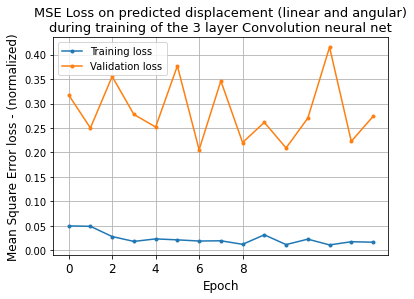

In [34]:
plt.plot(loss_log['train'], '.-', label='Training loss')
plt.plot(loss_log['v'], '.-', label='Validation loss')
plt.xticks(range(0,10, 2), fontsize=12)
plt.title("MSE Loss on predicted displacement (linear and angular)\nduring training of the 3 layer Convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
plt.grid()

In [64]:
def train(model, train_loader, v_loader, n_epochs):
    device = torch.device('cpu')
    model.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    loss_logger = {'loss':[], 'vloss':[], 'loss_class':[], 'vloss_class':[]}

    for epoch in range(n_epochs):
        print(f"Starting epoch {epoch}/{n_epochs}", end = ' ')
        model.train()
        for batch, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model.forward(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            loss_logger['loss'].append(loss.item())
        print(loss.item())
            # if batch % 100 == 0:
            #     model.eval()
            #     with torch.no_grad():
            #         print(f"batch {batch}/{len(train_loader)}; loss={loss.item():>6f}")
            #         loss_logger['loss'].append(loss.item())
            #         loss_per_class = ((y - y_pred)**2).mean(axis=0)
            #         loss_logger['loss_class'].append(loss_per_class)
            #         x_val, y_val = v_loader.dataset.x.to(device), v_loader.dataset.y.to(device)
            #         y_pred = model.forward(x_val)
            #         v_loss_per_class = ((y_val - y_pred)**2).mean(axis=0)
            #         v_loss = v_loss_per_class.mean()
            #         loss_logger['vloss'].append(v_loss)
            #         loss_logger['vloss_class'].append(v_loss_per_class)
            #         print(f"Epoch {epoch}/{n_epochs}; batch {batch}; v_loss={v_loss:>6f}")
            #     model.train()

    return loss_logger

In [65]:
loss_log = train(model_mlp, train_loader, v_loader, n_epochs=30)

Starting epoch 0/30 0.41642212867736816
Starting epoch 1/30 0.3613486588001251
Starting epoch 2/30 0.3326757848262787
Starting epoch 3/30 0.31079789996147156
Starting epoch 4/30 

: 

: 

In [25]:
loss_log['vloss'] = np.array([v.item() for v in loss_log['vloss']])

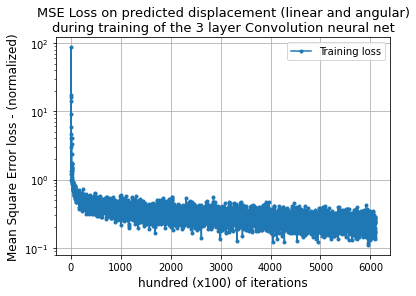

In [51]:
plt.plot(loss_log['loss'], '.-', label='Training loss')
#plt.plot(loss_log['vloss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted displacement (linear and angular)\nduring training of the 3 layer Convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("hundred (x100) of iterations", fontsize=12)
plt.yscale('log')
plt.legend()
plt.grid()

In [24]:
np.array([np.array([6, 7, 8]), np.array([6, 9])], dtype=object)

array([array([6, 7, 8]), array([6, 9])], dtype=object)

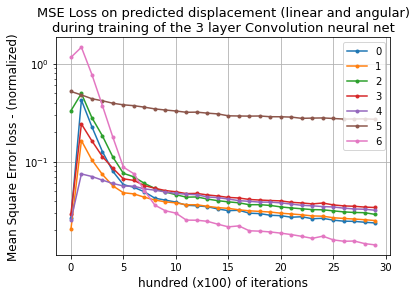

In [60]:
plt.plot(torch.stack(loss_log['vloss_class']).numpy(), '.-')
plt.yscale('log')
#plt.plot(loss_log['loss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted displacement (linear and angular)\nduring training of the 3 layer Convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("hundred (x100) of iterations", fontsize=12)
plt.legend(range(7))
plt.grid()

In [49]:
torch.cat(loss_log['loss_class']).numpy()

array([0.77936435, 0.28381696, 0.90843534, 0.32577306, 0.10911089,
       0.58005923, 2.516416  , 0.4304769 , 0.15759438, 0.5594385 ,
       0.21217299, 0.05298171, 0.543753  , 1.4274449 , 0.19633065,
       0.09309821, 0.23398718, 0.14283971, 0.08069934, 0.358763  ,
       0.6636641 , 0.10399301, 0.04556169, 0.20339209, 0.11771308,
       0.05988663, 0.3675208 , 0.3252234 , 0.04138189, 0.04553068,
       0.06904925, 0.05692952, 0.03010596, 0.3368208 , 0.13355511,
       0.0531782 , 0.04816332, 0.0799436 , 0.0671792 , 0.05137894,
       0.38115495, 0.09722846, 0.03433692, 0.04851123, 0.07042106,
       0.04601322, 0.04340365, 0.32127583, 0.07001012, 0.03663394,
       0.02914176, 0.06209106, 0.03711032, 0.04560969, 0.3351309 ,
       0.07182173, 0.05039901, 0.02620028, 0.05314193, 0.04035052,
       0.05979224, 0.3462645 , 0.04889506, 0.02496699, 0.02726395,
       0.02548315, 0.03779403, 0.03736064, 0.3276405 , 0.02920969,
       0.0351723 , 0.04051785, 0.0345798 , 0.06518136, 0.03899

In [57]:
del model_mlp

In [58]:

torch.cuda.empty_cache()

In [53]:
torch.save(model_mlp.state_dict(), DIR_PATH + '/data/model_mlp_20epochs_new_dataset8jul.pth')

In [20]:
np.savez_compressed(DIR_PATH + '/data/loss_resnet18_5epochs', **loss_log)

/Users/hubzer/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/npyio.py:719: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  val = np.asanyarray(val)
/Users/hubzer/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


In [ ]:
H = 64
K=11
S=2
P=2
D=1
H = int((H + 2*P - D*(K-1) - 1) / S + 1)
print(H)

In [ ]:
H = 29
K=3
S=2
P=0
D=1
H = int((H + 2*P - D*(K-1) - 1) / S + 1)
print(H)

In [ ]:
H = 14
K=5
S=1
P=2
D=1
H = int((H + 2*P - D*(K-1) - 1) / S + 1)
print(H)

In [ ]:
H = 14
K=3
S=2
P=0
D=1
H = int((H + 2*P - D*(K-1) - 1) / S + 1)
print(H)

In [ ]:
H = 6
K=3
S=1
P=1
D=1
H = int((H + 2*P - D*(K-1) - 1) / S + 1)
print(H)

In [ ]:
H = 6
K=3
S=2
P=0
D=1
H = int((H + 2*P - D*(K-1) - 1) / S + 1)
print(H)

In [63]:
with torch.no_grad():
    y_pred = model(test_set.x).numpy()

In [ ]:
for i in range(7):
    print(y_pred[:, i].min(), y_pred[:, i].max())

In [66]:
test_set.y.shape

torch.Size([590, 7])

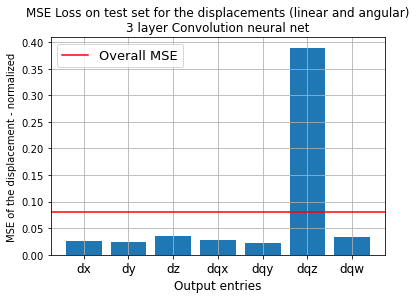

In [67]:
plt.bar(['dx', 'dy', 'dz', 'dqx', 'dqy', 'dqz', 'dqw'], ((test_set.y - y_pred)**2).mean(axis=0))
plt.xticks(fontsize=12)
plt.axhline(((test_set.y - y_pred)**2).mean(), color='r', label='Overall MSE')
plt.legend(fontsize=13)
plt.title('MSE Loss on test set for the displacements (linear and angular)\n3 layer Convolution neural net')
plt.xlabel('Output entries', fontsize=12)
plt.ylabel('MSE of the displacement - normalized')
plt.grid()

In [ ]:
plt.plot(((normal_test_y - y_pred)**2)[:100, :])
plt.legend(range(7))

In [ ]:
c = torch.nn.MSELoss()

In [ ]:
ya = torch.tensor([[0, 1], [1, 1]], dtype=torch.float32)
yb = torch.tensor([[1, 1], [1, 1]], dtype=torch.float32)
c(ya, yb)

In [ ]:
np.random.seed(123)
np.random.uniform(), np.random.randint(0,5, 10)

In [ ]:
np.random.randint(0,5)

In [ ]:
a = [1, 5, 7]

In [ ]:
a[[0, 2]]

In [ ]:
a = {0, 3, 8}

In [ ]:
a

In [ ]:
a = zip([0, 8], [7, 9])

In [ ]:
.025 / .05